# Mapping UK data sets

Import dependencies and create the Spark context

In [1]:
from __future__ import print_function

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, struct, count, col, isnan, when, year, month
from pyspark.sql.types import BooleanType, IntegerType, FloatType, DateType, StringType

import os
import sys
from datetime import datetime
if sys.version_info.major == 2:
    from pathlib2 import Path
else:
    from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
import pyproj
import shapefile as shp
from matplotlib import pyplot as plt
from matplotlib import colorbar, colors
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon, Rectangle
from matplotlib.text import Annotation
from tabulate import tabulate

plt.rcParams['figure.dpi'] = 100

spark = SparkSession.builder.appName("uk_data_mapping").config(conf=SparkConf()).getOrCreate()

SAMPLE = False  # Set to True to work with a subset of the data

Current Spark configuration

In [2]:
spark.sparkContext._conf.getAll()

[('spark.app.id', 'local-1541005004370'),
 ('spark.driver.host', '192.168.1.8'),
 ('spark.default.parallelism', '64'),
 ('spark.driver.port', '34753'),
 ('spark.executor.id', 'driver'),
 ('spark.task.maxFailures', '1'),
 ('spark.driver.memory', '1g'),
 ('spark.app.name', 'PySparkShell'),
 ('spark.pyspark.python', '/usr/bin/python3.6'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.local.dir', '/media/csk13/d/scratch'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

---

## Ordinance Survey Boundary-Line data set
The boundary line data set contains `.shp` _shapefiles_ which store the shapes of various UK administrative regions along with data associated with each region. The data set is freely available and can be [downloaded](https://www.ordnancesurvey.co.uk/business-and-government/products/boundary-line.html) from the ordinance survey website.

In [3]:
!tree ${DATA_BDLINE}/Data/GB

/home/csk13/src/uk-data-mapping/bdline/Data/GB
├── county_electoral_division_region.dbf
├── county_electoral_division_region.prj
├── county_electoral_division_region.shp
├── county_electoral_division_region.shx
├── county_region.dbf
├── county_region.prj
├── county_region.shp
├── county_region.shx
├── district_borough_unitary_region.dbf
├── district_borough_unitary_region.prj
├── district_borough_unitary_region.shp
├── district_borough_unitary_region.shx
├── district_borough_unitary_ward_region.dbf
├── district_borough_unitary_ward_region.prj
├── district_borough_unitary_ward_region.shp
├── district_borough_unitary_ward_region.shx
├── european_region_region.dbf
├── european_region_region.prj
├── european_region_region.shp
├── european_region_region.shx
├── greater_london_const_region.dbf
├── greater_london_const_region.prj
├── greater_london_const_region.shp
├── greater_london_const_region.shx
├── high_water_polyline.dbf
├── high_water_polyline.prj
├── high_water_polyline.shp
├── high_

Let's take a look at the `district_borough_unitary_region` data set

In [4]:
BDLINE_DIR = os.getenv('DATA_BDLINE')
BDLINE_DISTRICT_CSV = os.path.join(BDLINE_DIR, 'Data/GB/district_borough_unitary_region.shp')
BDLINE_COUNTY_CSV = os.path.join(BDLINE_DIR, 'Data/Supplementary_Ceremonial/Boundary-line-ceremonial-counties_region.shp')
BDLINE_LONDON_CSV = os.path.join(BDLINE_DIR, 'Data/GB/greater_london_const_region.shp')

In [5]:
sf_district = shp.Reader(BDLINE_DISTRICT_CSV)

Available fields in the shapefile data

In [6]:
sf_district.fields

[('DeletionFlag', 'C', 1, 0),
 ['NAME', 'C', 60, 0],
 ['AREA_CODE', 'C', 3, 0],
 ['DESCRIPTIO', 'C', 50, 0],
 ['FILE_NAME', 'C', 50, 0],
 ['NUMBER', 'N', 11, 0],
 ['NUMBER0', 'N', 11, 0],
 ['POLYGON_ID', 'N', 11, 0],
 ['UNIT_ID', 'N', 11, 0],
 ['CODE', 'C', 9, 0],
 ['HECTARES', 'N', 12, 3],
 ['AREA', 'N', 12, 3],
 ['TYPE_CODE', 'C', 2, 0],
 ['DESCRIPT0', 'C', 25, 0],
 ['TYPE_COD0', 'C', 3, 0],
 ['DESCRIPT1', 'C', 36, 0]]

Number of records

In [7]:
sf_district.numRecords

380

Let's take a look at the first record

In [8]:
sf_district.record(0)  # or sf_district.records()[0]

['Wycombe District',
 'DIS',
 'District',
 'BUCKINGHAMSHIRE_COUNTY',
 5,
 377,
 51844,
 11882,
 'E07000007',
 32457.21,
 0.0,
 'AA',
 'CIVIL ADMINISTRATION AREA',
 '',
 '']

The geometry for each of the districts is defined within the `.shp` file and can be accessed through the `shape` and `shapes` methods. According to the [Boundary-Line User Manual](https://digimap.edina.ac.uk/webhelp/os/data_files/os_manuals/boundary-line-user-guide_1_18.pdf) (p.91), all Ordnance Survey geometry is defined in the OSGB36 projection.

>**National Grid**  
A unique referencing system that can be applied to all Ordnance Survey maps of Great Britain (GB) at all
scales. It is used by Ordnance Survey on all post-war mapping to provide an unambiguous spatial reference
in Great Britain for any place or entity whatever the map scale. The National Grid is defined by the OSGB36®
spheroid.

In [9]:
sf_district.shape(0).points[:5]

[(476152.20059080864, 183567.80351806417),
 (476146.50325358775, 183569.70297435045),
 (476164.7990441711, 183643.40187825868),
 (476191.10078908363, 183743.60319592984),
 (476205.4966657661, 183806.2952505159)]

Some shapes contain multiple components so care must be taken to draw each as a separate closed polygon. For multi-part shapes, the list `parts` will contain multiple offsets which indicate the location of the first point in the corresponding `points` array.

In [10]:
sf_district.shape(5).parts

[0, 6570]

It is necesary to map district codes to the associated shp record

In [11]:
district_to_shp_record_map = {
    x[8]: i for i, x in enumerate(sf_district.records())
}

---

## UK HM Land Registry Price Paid data set

Data on the price paid for houses in England and Wales from 1995 to present can be [downloaded](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads) for free from HM Land Registry. Details about the data including a description of the fields are available [here](https://www.gov.uk/guidance/about-the-price-paid-data).

It is stated that data from the most recent 2 months is **not reliable** due to the typical time of between 2 weeks and 2 months between the sale of a property and registration.

>The amount of time between the sale of a property and the registration of this information with HM Land Registry varies. It typically ranges between 2 weeks and 2 months. Data for the two most recent months is therefore incomplete and does not give an indication of final monthly volumes. 

In [12]:
PP_CSV = os.getenv('DATA_PP_CSV')

Let's take a look at the first few entries in the data set

In [13]:
!head -3 $PP_CSV

"{7130F2C1-B3E4-41A5-9103-3DC40A6A5466}","166500","1995-11-22 00:00","CM23 4PA","D","Y","F","19","","MAYFLOWER GARDENS","BISHOP'S STORTFORD","BISHOP'S STORTFORD","EAST HERTFORDSHIRE","HERTFORDSHIRE","A","A"
"{76F6D626-1D6C-4744-B12E-3A364DB17E29}","59000","1995-09-27 00:00","L12 0AY","D","N","L","7","","TRENT CLOSE","LIVERPOOL","LIVERPOOL","LIVERPOOL","MERSEYSIDE","A","A"
"{E8BA1D5E-93DC-4896-AAA2-3A365F979FD9}","118000","1995-12-15 00:00","SL3 8XX","D","N","F","24","","SOUTHWOLD SPUR","SLOUGH","SLOUGH","SLOUGH","SLOUGH","A","A"


### Loading the data into python
The dataset is approximately 4GB in size, and although this is not very big, it's big enough to be problematic to work with. Attempting to load all of the data into a Pandas DataFrame exhausts all system memory. Instead the data can be loaded into a Spark data frame.

In [14]:
%%time
pp = spark.read.csv(PP_CSV, header=False, inferSchema=True)

CPU times: user 4.34 ms, sys: 8.59 ms, total: 12.9 ms
Wall time: 25.3 s


Number of rows in the dataset

In [15]:
%%time
# 64 partitions
pp.count()

CPU times: user 3.28 ms, sys: 16 µs, total: 3.3 ms
Wall time: 13.4 s


23739061

The dataset does not contain column names so these must be added manually based on the information found through the link above.

In [16]:
col_names = {
    0: 'id',
    1: 'price',
    2: 'date_of_transfer',
    3: 'postcode',
    4: 'property_type',
    5: 'is_new',
    6: 'duration',
    7: 'PAON',
    8: 'SAON',
    9: 'street',
    10: 'locality',
    11: 'town_city',
    12: 'district',
    13: 'county',
    14: 'ppd_category_type',
    15: 'record_status',
}

col_name_list = [
    v for k, v in sorted(
        [(k, v) for k, v in col_names.items()], key=lambda x: x[0]
    )
]

Rename all the columns in the dataframe

In [17]:
%%time
# 64 partitions
pp = pp.toDF(*col_name_list)

CPU times: user 2.33 ms, sys: 704 µs, total: 3.03 ms
Wall time: 40.1 ms


Display the schema for the dataframe - field names, types

In [18]:
pp.printSchema()

root
 |-- id: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- date_of_transfer: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- is_new: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- PAON: string (nullable = true)
 |-- SAON: string (nullable = true)
 |-- street: string (nullable = true)
 |-- locality: string (nullable = true)
 |-- town_city: string (nullable = true)
 |-- district: string (nullable = true)
 |-- county: string (nullable = true)
 |-- ppd_category_type: string (nullable = true)
 |-- record_status: string (nullable = true)



Any records with missing postcodes must be removed.

In [19]:
pp = pp.dropna(subset=['postcode'])

Take a sample of the data if `SAMPLE=True` as this will be quicker for exploratory work.

In [20]:
if SAMPLE == True:
    pp = pp_full
    pp_full = pp
    pp = pp.sample(False, 0.05)

In [21]:
%%time
# 64 partitions?
pp.count()

CPU times: user 1.69 ms, sys: 510 µs, total: 2.2 ms
Wall time: 13.8 s


23705551

Let's take a look at a few randomly selected entries in the data set to see what we're working with

In [22]:
pprint([row.asDict() for row in pp.rdd.take(2)])

[{'PAON': '19',
  'SAON': None,
  'county': 'HERTFORDSHIRE',
  'date_of_transfer': '1995-11-22 00:00',
  'district': 'EAST HERTFORDSHIRE',
  'duration': 'F',
  'id': '{7130F2C1-B3E4-41A5-9103-3DC40A6A5466}',
  'is_new': 'Y',
  'locality': "BISHOP'S STORTFORD",
  'postcode': 'CM23 4PA',
  'ppd_category_type': 'A',
  'price': 166500,
  'property_type': 'D',
  'record_status': 'A',
  'street': 'MAYFLOWER GARDENS',
  'town_city': "BISHOP'S STORTFORD"},
 {'PAON': '7',
  'SAON': None,
  'county': 'MERSEYSIDE',
  'date_of_transfer': '1995-09-27 00:00',
  'district': 'LIVERPOOL',
  'duration': 'L',
  'id': '{76F6D626-1D6C-4744-B12E-3A364DB17E29}',
  'is_new': 'N',
  'locality': 'LIVERPOOL',
  'postcode': 'L12 0AY',
  'ppd_category_type': 'A',
  'price': 59000,
  'property_type': 'D',
  'record_status': 'A',
  'street': 'TRENT CLOSE',
  'town_city': 'LIVERPOOL'}]


The `date_of_transfer` field is a string specifying the date at which the sale took place. This needs to be converted to a `datetime` object (`spark.sql.types.DateType`) in order to manipulate it as a date.

In [23]:
%%time

def date_str_to_datetime(date_str, datetime_format='%Y-%m-%d %H:%M'):
    try:
        return datetime.strptime(date_str, datetime_format).date()
    except Exception:
        return
    
pp = pp.withColumn(
    'date_of_transfer_datetime',
    udf(lambda x: date_str_to_datetime(x), DateType())(pp['date_of_transfer'])
).dropna(subset=['date_of_transfer_datetime'])

CPU times: user 12.8 ms, sys: 4.24 ms, total: 17 ms
Wall time: 54.8 ms


### House sale volume by year

Now we can see how many sales took place each year.

In [24]:
%%time
# 64 partitions
sales_by_year = pp.groupby(year(pp['date_of_transfer_datetime']).alias('year')).count().orderBy('year').toPandas()
sales_by_year = sales_by_year.iloc[:-1]  # Trim last year with incomplete data

CPU times: user 60.7 ms, sys: 22 ms, total: 82.7 ms
Wall time: 2min 13s


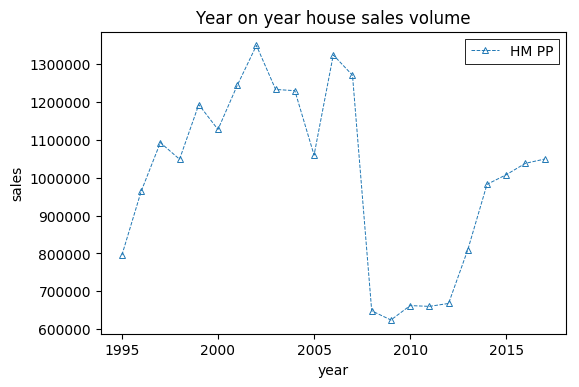

In [25]:
plt.rcParams['figure.dpi'] = 100
plt.plot(sales_by_year['year'], sales_by_year['count'], linestyle='--', marker='^', 
         markerfacecolor='none', markeredgewidth=0.7, label=r'HM PP')
plt.legend()
plt.title('Year on year house sales volume')
plt.xlabel('year')
plt.ylabel('sales')
plt.show()

---

## Mapping post codes into map tile regions
The code point open data set includes details of which county each UK postcode belongs. The data is freely available for [download](https://www.ordnancesurvey.co.uk/business-and-government/products/code-point-open.html) from Ordinance Survey.

In [26]:
CPO_DIR = os.getenv('DATA_CODEPO')

In [27]:
!tree $CPO_DIR | head -10

/home/csk13/src/uk-data-mapping/codepo_gb
├── Data
│   └── CSV
│       ├── ab.csv
│       ├── al.csv
│       ├── ba.csv
│       ├── bb.csv
│       ├── b.csv
│       ├── bd.csv
│       ├── bh.csv


The postcode data is split into many `.csv` files, each one named based on the [postcode area code](https://en.wikipedia.org/wiki/List_of_postcode_areas_in_the_United_Kingdom) - the first one or two letters of the post code.

A file specifying the column headers is provided. Let's take a look.

In [28]:
!head $CPO_DIR/Doc/Code-Point_Open_Column_Headers.csv

PC,PQ,EA,NO,CY,RH,LH,CC,DC,WC
Postcode,Positional_quality_indicator,Eastings,Northings,Country_code,NHS_regional_HA_code,NHS_HA_code,Admin_county_code,Admin_district_code,Admin_ward_code


Let's take a look at a few entries from one of the .csv files

In [29]:
!head -3 $CPO_DIR/Data/CSV/ab.csv

"AB101AB",10,394235,806529,"S92000003","","S08000020","","S12000033","S13002842"
"AB101AF",10,394181,806429,"S92000003","","S08000020","","S12000033","S13002842"
"AB101AG",10,394230,806469,"S92000003","","S08000020","","S12000033","S13002842"


Building mapping between postcode and district code.

In [30]:
%%time
postarea_code_fnames = [str(path) for path in (Path(CPO_DIR) / 'Data/CSV').glob('*.csv')]

postcode_to_district_map = {
    x[1].replace(' ', '').upper(): x[2] 
    for fname in postarea_code_fnames 
    for x in pd.read_csv(fname, usecols=(0,8,), header=None).itertuples()
}

CPU times: user 2.47 s, sys: 183 ms, total: 2.65 s
Wall time: 2.73 s


In [31]:
len(postcode_to_district_map)

1698194

---

## Mean house prices by district

The postcodes in the Code Point Open dataset and the Price Paid dataset are in different formats. It's necessary to remove spaces from the postcodes in the Price Paid dataset.

In [32]:
pp = pp.withColumn('postcode', udf(lambda x: x.replace(' ', '').upper(), StringType())(pp['postcode']))

In order to aggregate data at the district level we first need to assign each row to a district using the mapping defined by `postcode_to_district_map`.

In [33]:
pp = pp.withColumn(
    'district_id', udf(postcode_to_district_map.get, StringType())(pp['postcode'])
).dropna(subset=['district_id'])

Create a Pandas DataFrame containing the mean sale price for each year and district

In [34]:
mean_prices = pp.groupby([year(pp['date_of_transfer_datetime']).alias('year'), 'district_id'])\
                .agg({'price': 'mean'})\
                .withColumnRenamed('avg(price)', 'price_mean')\
                .toPandas()
mean_prices = mean_prices.set_index(['year', 'district_id']).sort_index(level=0)

Some sales occur in one of the districts bordering Scotland in several of the years but not all. Filter out any data corresponding to districts which are not in England or Wales.

In [35]:
def filter_districts(district):
    """Returns True if district is in England or Wales else False."""
    return district.upper().startswith('E') or district.upper().startswith('W')

mean_prices = mean_prices[mean_prices.index.map(lambda x: filter_districts(x[1]))]

Years present in the dataset

In [38]:
years = mean_prices.index.levels[0].values

Prices need to be adjusted for inflation in order to be meaningful. RPI data is available for download from the ONS from [here](https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/czbh/mm23).

In [39]:
UK_RPI_CSV = os.getenv('DATA_RPI_CSV')
rpi = pd.read_csv(UK_RPI_CSV)

In [40]:
rpi.columns = ['year', 'rpi']
rpi.set_index('year', inplace=True)
rpi = rpi.reindex([str(y) for y in years])
rpi.rpi = rpi.rpi.map(float)
rpi.index = rpi.index.map(int)
rpi.loc[years[-1]] = 0.
rpi = rpi.sort_index()

Convert RPI inflation for each year into a multiplicative factor to map prices in each year to present day prices.

In [41]:
rpi['factor'] = np.cumprod(1. + 0.01 * rpi['rpi'].values[::-1])[::-1]

In [42]:
rpi.sort_index(ascending=False).head()

,rpi,factor
year,,
2018,0.0,1.000000
2017,3.6,1.036000
2016,1.8,1.054648
2015,1.0,1.065194
2014,2.4,1.090759


Apply cumulative inflation to mean price data.

In [43]:
for y in mean_prices.index.levels[0]:
    mean_prices.loc[(y, np.s_[:]), 'price_mean'] *= rpi.loc[y].factor

Drop the current year's data as it is incomplete

In [44]:
mean_prices = mean_prices.drop(mean_prices.index.levels[0].values[-1])
mean_prices.index = mean_prices.index.remove_unused_levels()  # Ridiculous that this is required, but yeah... https://github.com/pandas-dev/pandas/issues/2770
years = years[:-1]

---
### GDP, population and employment data
GDP estimates adjusted for inflation are available for download in `.csv` format from ONS [here](https://www.ons.gov.uk/economy/grossdomesticproductgdp/timeseries/abmi/ukea). 

In [49]:
UK_GDP_CSV = os.getenv('DATA_GDP_CSV')
uk_gdp = pd.read_csv(UK_GDP_CSV)

uk_gdp.columns = ['year', 'gdp']
uk_gdp.set_index('year', inplace=True)
uk_gdp = uk_gdp.reindex([str(y) for y in years])
uk_gdp.gdp = uk_gdp.gdp.map(float)
uk_gdp.index = uk_gdp.index.map(int)
uk_gdp = uk_gdp.sort_index()

Population estimates are available for download in `.xls` format from ONS [here](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/adhocs/004356ukpopulationestimates1851to2014).

In [50]:
UK_POP_CSV = os.getenv('DATA_POP_CSV')
uk_pop = pd.read_csv(UK_POP_CSV)

uk_pop.columns = ['year', 'population']
uk_pop.set_index('year', inplace=True)
uk_pop.population = uk_pop.population.map(lambda s: int(s.replace(',', '')))
uk_pop = uk_pop.reindex(years)
uk_pop = uk_pop.sort_index()

Population estimates in this dataset only go up to 2014 so predict population for recent years based on the last 5 years for which data is available

In [51]:
pop_est = np.poly1d(np.polyfit(uk_pop.loc[2009:2014].index, uk_pop.loc[2009:2014].population, 1))
isna_idx = uk_pop.population.isna()
uk_pop.population[isna_idx] = uk_pop[isna_idx].index.map(pop_est).values

Unemployment rates and Average Weekly Earnings can be obtained from the Labour Market Survey dataset available in `.csv` format from ONS [here](https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/employmentandemployeetypes/datasets/labourmarketstatistics). 

In [52]:
UK_LMS_CSV = os.getenv('DATA_LMS_CSV')
lms_cols_map = {
    'Title': 'year',
    'Unemployment rate (aged 16 and over, seasonally adjusted)': 'unemployment_rate',
    'LMSB SA AWE regular pay WE': 'awe',  # -> average weekly earnings before bonuses adjusted for inflation
}
uk_lms = pd.read_csv(UK_LMS_CSV, usecols=lms_cols_map.keys(), dtype=str)

uk_lms = uk_lms.rename(columns=lms_cols_map)
uk_lms.set_index('year', inplace=True)
uk_lms = uk_lms.reindex([str(y) for y in years])
uk_lms = uk_lms.sort_index()
uk_lms.index = uk_lms.index.map(int)
uk_lms.unemployment_rate = uk_lms.unemployment_rate.map(float)
uk_lms.awe = uk_lms.awe.map(float)

Calculating affordability of 10% deposit in terms of mean average income.

In [53]:
uk_lms['aae'] = 52. * uk_lms['awe']
for year in uk_lms.index.values:
    mean_prices.loc[(year, np.s_[:]), 'affordability'] = mean_prices.loc[(year, np.s_[:]), 'price_mean'].values / uk_lms.aae[year]

Comparing price over time for Sheffield (The North) and Oxford (The South).

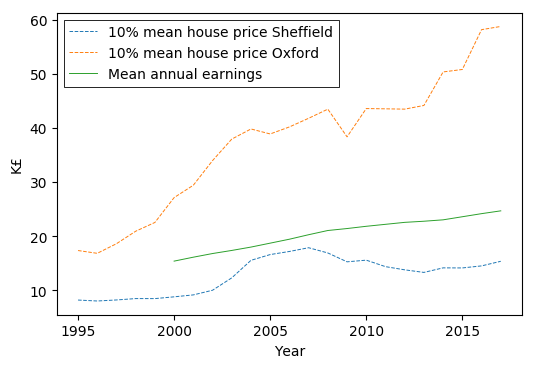

In [71]:
plt.rcParams['figure.dpi'] = 100
plt.plot(mean_prices.index.levels[0], 0.1 * mean_prices.loc[(np.s_[:], 'E08000016'), 'price_mean'] / 1000.,
         ls='--', label='10% mean house price Sheffield')
plt.plot(mean_prices.index.levels[0], 0.1 * mean_prices.loc[(np.s_[:], 'E07000178'), 'price_mean'] / 1000.,
         ls='--', label='10% mean house price Oxford')
plt.plot(uk_lms.index, uk_lms.aae / 1000., label='Mean annual earnings')
plt.xlabel('Year')
plt.ylabel('K£')
plt.legend()

---
### Plotting map

Dictionary to isolate London districts.

In [54]:
LONDON_POSTCODES_CSV = os.getenv('DATA_LDN_POSTCODES_CSV')
london_districts_df = pd.read_csv(LONDON_POSTCODES_CSV, usecols=(10,))
london_districts = {x: None for x in london_districts_df['District Code'].unique()}
sf_london_idx = np.array([i for i, rec in enumerate(sf_district.records()) if rec[8] in london_districts])
assert len(sf_london_idx) == len(london_districts)

The `pyproj` package is useful for converting between geographic projections. Projection formats are specified by [ESPG codes](http://spatialreference.org/).

In [55]:
wgs84=pyproj.Proj("+init=EPSG:4326")     # LatLon with WGS84 datum used by GPS units and Google Earth
osgb36 = pyproj.Proj("+init=EPSG:27700") # UK Ordnance Survey, 1936 datum

London_LonLat = (-0.1278, 51.5074)        # Lon-Lat geospatial coords for London
London_osgb36 = osgb36(*London_LonLat)   # Lon-Lat OS National Grid coords for London

OSGB36 Coords of the top10 UK cities by population. List of UK cities by population is available [here](http://www.citymayors.com/gratis/uk_topcities.html). WGS84 Lat-Long coordinates were obtained from Google Maps. It is important to note that **positive latitude** specifies and angle **North** of the equator and **positive longitude** specifies an angle **East** of the prime meridian.

In [56]:
uk_cities_top10_wgs84 = {
    'London': [(51.5074, -0.1278), (50.523194, 0.355571)],
    'Birmingham': [(52.4862, -1.8904), (50.253231, -1.88417)],
    'Leeds': [(53.8008, -1.5491), (54.775133, -0.875307)],
    'Glasgow': [(55.8642, -4.2518), (54.846665, -7.336002)],
    'Sheffield': [(53.3811, -1.4701), (53.150688, 0.603948)],
    'Bradford': [(53.7960, -1.7594), (55.177306, -1.134410)],
    'Liverpool': [(53.4084, -2.9916), (53.597492, -5.146998)],
    'Edinburgh': [(55.9533, -3.1883), (56.308727, -2.116987)],
    'Manchester': [(53.4808, -2.2426), (54.004974, -5.715788)],
    'Bristol': [(51.4545, -2.5879), (50.149561, -3.247066)],
}

uk_cities_top10_osgb36 = {
    k: osgb36(lon, lat) 
    for k, ((lat, lon), _) in uk_cities_top10_wgs84.items()
}
uk_cities_top10_labels_osgb36 = {
    k: osgb36(lon, lat) 
    for k, (_, (lat, lon)) in uk_cities_top10_wgs84.items()
}

In [57]:
uk_cities_top10_osgb36

{'London': (529915.8259598681, 180433.9938870187),
 'Birmingham': (407441.59663470316, 287633.45594173216),
 'Leeds': (429694.25737852394, 433951.22248979274),
 'Glasgow': (259095.16632049525, 665735.5205742274),
 'Sheffield': (435244.32054710225, 387299.03216908325),
 'Bradford': (415846.6846645916, 433349.79639267735),
 'Liverpool': (334090.2975010383, 390663.0040515137),
 'Edinburgh': (325808.153663839, 673996.2847710882),
 'Manchester': (383902.0295161803, 398286.245722139),
 'Bristol': (359155.7086262001, 173053.65671517007)}

Functions for plotting shapefile with districts coloured by mean price

In [58]:
LDN_SCALE = 5.
LDN_TRANS = np.array([-2.7e6, -6.0e5])

def create_shp_patches(sf):
    """Returns tuple containing UK and London patches for shapefile `sf`."""
    # Create list of polygon patches for all districts
    patches_uk = []
    for i, shape in enumerate(sf.shapes()):
        for points in np.split(np.array(shape.points), shape.parts)[1:]:
            polygon = Polygon(points, closed=True)
            patches_uk.append(polygon)

    # Create list of polygon patches for London districts
    patches_ldn = []
    for idx in sf_london_idx:
        for points in np.split(np.array(sf.shape(idx).points), sf.shape(idx).parts)[1:]:
            points *= LDN_SCALE  # Increase size of London districts
            points += LDN_TRANS  # Shift London districts
            polygon = Polygon(points, closed=True)
            patches_ldn.append(polygon)

    return (patches_uk, patches_ldn)


def plot_map_for_year(year, affordability=False, fname=None):
    if affordability:
        mean_price_year = np.array([
            mean_prices.loc[year, rec[8]].affordability if rec[8] in mean_prices.loc[year].index else 0.
            for rec in sf_district.records()
        ])
    else:
        mean_price_year = np.array([
            mean_prices.loc[year, rec[8]].price_mean if rec[8] in mean_prices.loc[year].index else 0.
            for rec in sf_district.records()
        ])       

    fig, ax = plt.subplots(1, figsize=(4, 4))
    ax.set_aspect('equal')  # Need equal aspect ratio to prevent skewed geometry
    plt.axis('off')
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)

    # Set plot colormap and colours
    log_mean_price_year = np.where(mean_price_year > 0., np.log10(mean_price_year), 0.)
    if affordability:
        vmin, vmax = np.log10(1), np.log10(100)     
    else:
        vmin, vmax = np.log10(8.0e4), np.log10(2.0e6)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap('winter' if affordability else 'plasma')

    # Create patches from shp file
    patches, patches_ldn = create_shp_patches(sf_district)

    # Set colours for UK patches
    colours = []
    for i, shape in enumerate(sf_district.shapes()):
        for points in np.split(np.array(shape.points), shape.parts)[1:]:
            colour = cmap(norm(log_mean_price_year[i])) if log_mean_price_year[i] > 0. \
                else np.array([0.85, 0.85, 0.85, 1.])
            colours.append(colour)

    collection = PatchCollection(patches)
    collection.set_facecolor(colours)
    collection.set_linewidths(0.1)
    ax.add_collection(collection)

    # Set colours for London patches
    colours_ldn = []
    for idx in sf_london_idx:
        for points in np.split(np.array(sf_district.shape(idx).points), sf_district.shape(idx).parts)[1:]:
            colour = cmap(norm(log_mean_price_year[idx])) if log_mean_price_year[idx] > 0. \
                else np.array([0.85, 0.85, 0.85, 1.])
            colours_ldn.append(colour)

    collection_ldn = PatchCollection(patches_ldn)
    collection_ldn.set_facecolor(colours_ldn)
    collection_ldn.set_linewidths(0.1)
    ax.add_collection(collection_ldn)

    # Add boxes around London
    pos_lg, w_lg, h_lg = np.array([-2.e5, 1.6e5]), 3.2e5, 2.6e5
    pos_sm, w_sm, h_sm = (pos_lg - LDN_TRANS) / LDN_SCALE, w_lg / LDN_SCALE, h_lg / LDN_SCALE 
    rect_lg = Rectangle(pos_lg, w_lg, h_lg, angle=0.0, fill=False, linewidth=0.4, color='r')
    rect_sm = Rectangle(pos_sm, w_sm, h_sm, angle=0.0, fill=False, linewidth=0.4, color='r', zorder=10)
    ax.add_patch(rect_lg)
    ax.add_patch(rect_sm)

    ax.set_xlim((-3.e5, 8.0e5)) # Manually tune layout width...
    ax.set_ylim((-0., 1.22e6))  # ...and height.
    #ax.autoscale_view()        # automatic axis scaling leaves too much space...

    # Create colorbar independent of plot elements 
    cax = fig.add_axes([0.75, 0.4, 0.01, 0.2])
    cbar = colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
    cbar.ax.tick_params(labelsize=4)
    if affordability:
        cbar.set_ticks(np.log10([1., 10., 50.]))
        cbar.ax.set_yticklabels(['1', '10', '50'])
        cbar.set_label(u'Affordability factor', fontsize=5)
    else:
        cbar.set_ticks(np.log10([1.0e5, 5.0e5, 1.5e6]))
        cbar.ax.set_yticklabels(['0.1', '0.5', '1.5'])
        cbar.set_label(u'Mean price (M\u00a3)', fontsize=5)

    # Add points indicating 10 biggest cities
    for label, (x, y) in uk_cities_top10_osgb36.items():
        ax.scatter(x, y, label=label, c='black', s=2.)

    for label, (xy, xytext) in uk_cities_top10_wgs84.items():
        ax.annotate(label, xy=osgb36(xy[1], xy[0]), xytext=osgb36(xytext[1], xytext[0]), xycoords='data',
                    fontsize=3, horizontalalignment='left', verticalalignment='bottom', 
                    arrowprops=dict(color='black', shrink=0., width=0.05, headwidth=0.05, headlength=0.05))

    # Add additional labels to the plot
    ax.text(0.0, 0.90, 'UK House Prices', transform=ax.transAxes, fontsize=12)
    ax.text(0.0, 0.72, f'Year: {year}', transform=ax.transAxes, fontsize=9)
    ax.text(0.0, 0.64, f'Population: {uk_pop.population[year]/1.e6:1.1f}M', transform=ax.transAxes, fontsize=6)
    ax.text(0.0, 0.59, f'GDP: {uk_gdp.gdp[year]/1.e6:1.1f}T£', transform=ax.transAxes, fontsize=6)
    ax.text(0.0, 0.54, f'Unemployment: {uk_lms.unemployment_rate[year]:1.1f}%', transform=ax.transAxes, fontsize=6)
    ax.text(0.097, 0.137, 'Greater London', transform=ax.transAxes, fontsize=3)

    plt.draw()
    if affordability:
        plt.savefig(f'plot/map-affordability-{year}.png', dpi=600, bbox_inches='tight', pad_inches=0.1)
    else:
        plt.savefig(f'plot/map-mean-price-{year}.png', dpi=600, bbox_inches='tight', pad_inches=0.1)

Create directory to store plots

In [59]:
!mkdir -p plot

Average weekly earnings data is only available from 2000 - 2017. Save plots to disk for these years.

In [60]:
years = range(2000, 2018)
for year in years:
    plot_map_for_year(year)
    plt.close();

/home/csk13/src/uk-data-mapping/venv/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10


In [61]:
years = range(2000, 2018)
for year in years:
    plot_map_for_year(year, affordability=True)
    plt.close();

/home/csk13/src/uk-data-mapping/venv/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10


Create gif animation (requires `convert` and `gifsicle`)

In [70]:
!rm -f plot/*.gif
!for f in $(ls -d plot/*.png); do convert $f ${f%.png*}.gif; done
!gifsicle --colors 256 --delay=40 --loop $(ls plot/map-mean-price-*.gif | sort -g) > plot/map-mean-price-anim.gif
!gifsicle --colors 256 --delay=40 --loop $(ls plot/map-affordability-*.gif | sort -g) > plot/map-affordability-anim.gif
!convert -resize 50% plot/map-affordability-anim.gif plot/map-affordability-anim-small.gif
!convert -resize 50% plot/map-mean-price-anim.gif plot/map-mean-price-anim-small.gif

rm: cannot remove 'plot/*.gif': No such file or directory


Show plot for 2017

/home/csk13/src/uk-data-mapping/venv/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10


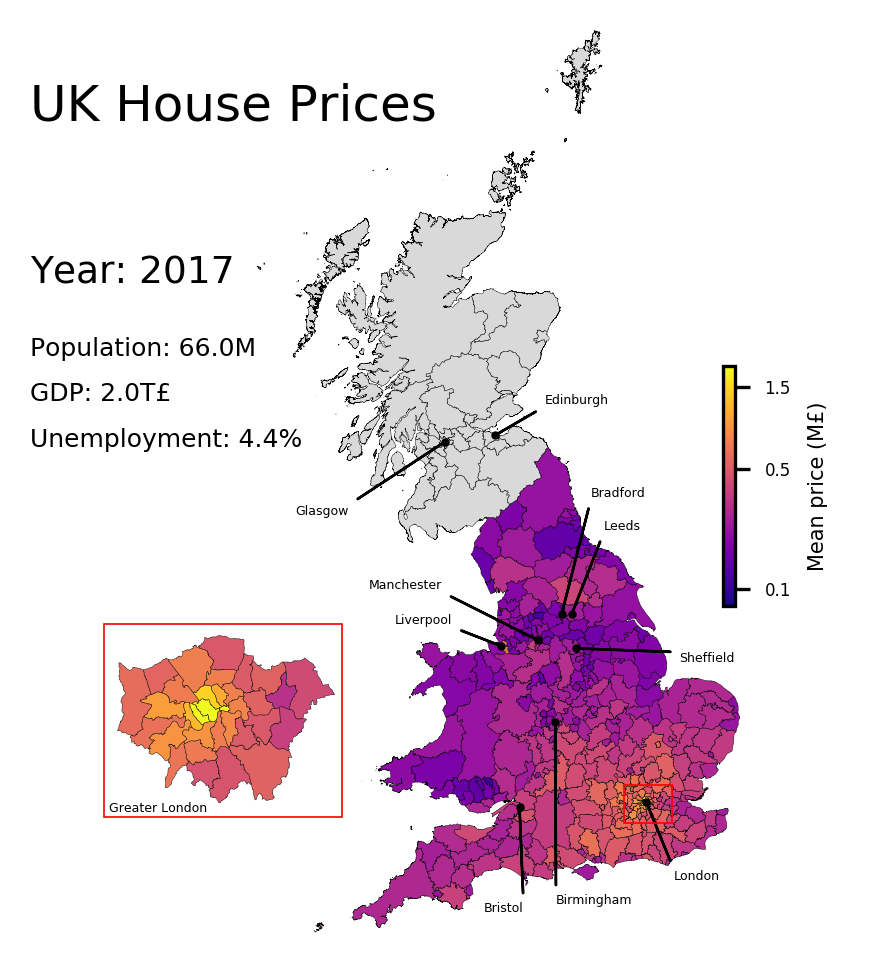

In [63]:
plt.rcParams['figure.dpi'] = 300
plot_map_for_year(2017)
plt.show()

/home/csk13/src/uk-data-mapping/venv/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10


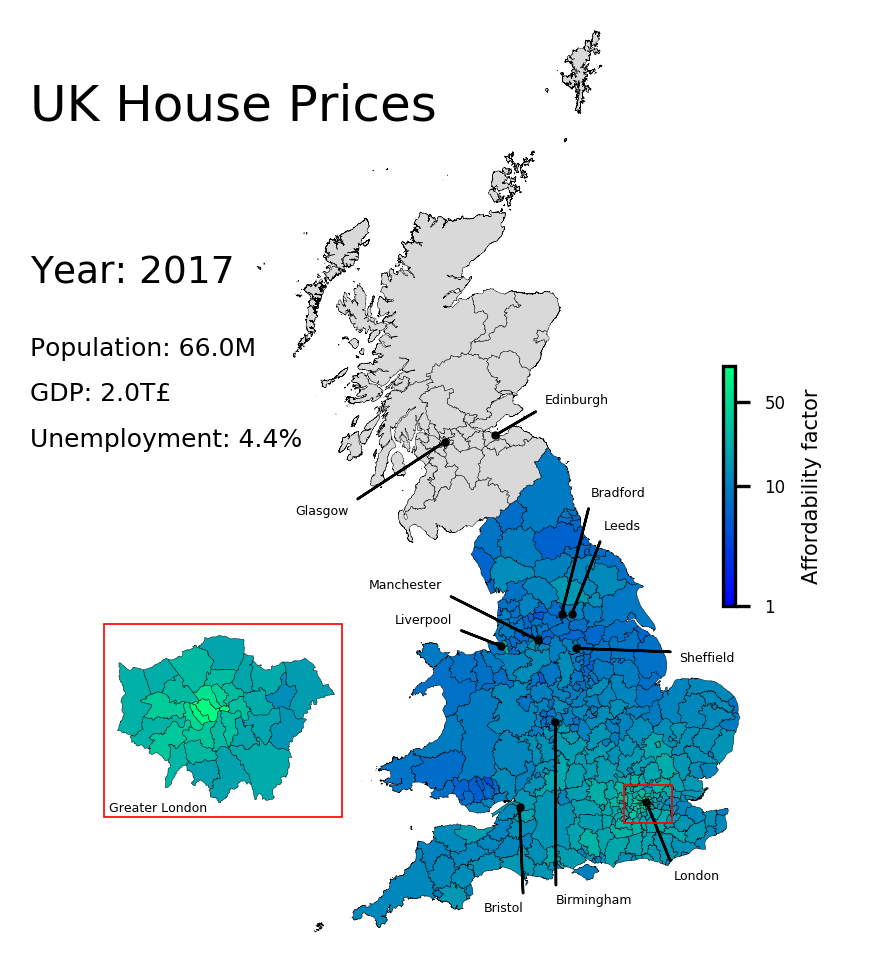

In [64]:
plt.rcParams['figure.dpi'] = 300
plot_map_for_year(2017, affordability=True)
plt.show()